# Snake species detection using transfer learning

### Importing the modules required

We will be using all these packages for this notebook, to install any missing packages you can use `python-pip`

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from shutil import copyfile
from os import listdir
from PIL import Image

plt.ion()   # interactive mode

### Splitting training data

Here we split our training data into training and validation set. The current validation set is 20% of the whole data. You can vary it using the `train_fraction` variable below

In [2]:
directories = ["../../data/train_data", "../../data/val_data"] 

for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)
        
for i in os.listdir("../../data/train"):
    if not os.path.exists(os.path.join(directories[0], i)):
        os.makedirs(os.path.join(directories[0], i))
    if not os.path.exists(os.path.join(directories[1], i)):
        os.makedirs(os.path.join(directories[1], i))    
        
train_fraction = 0.8

for i in os.listdir("../../data/train"):
    images = os.listdir(os.path.join("../../data/train/", i))
    n_images = len(images)
    n_train_images = int(n_images*train_fraction)
    n_val_images = n_images - n_train_images

    for j in range(n_train_images):
        copyfile(os.path.join(os.path.join("../../data/train/", i), images[j]) , os.path.join(os.path.join("../../data/train_data/", i), images[j]))
        
    for j in range(n_val_images):
        copyfile(os.path.join(os.path.join("../../data/train/", i), images[n_train_images + j]) , os.path.join(os.path.join("../../data/val_data/", i), images[n_train_images + j]))
    
for root in ['../../data/train_data', '../../data/val_data']:
    for i in listdir(root):
        for j in listdir(os.path.join(root, i)):
            try:
                img = Image.open(os.path.join(os.path.join(root, i), j)) # open the image file
                img.verify() # verify that it is, in fact an image
            except (IOError, SyntaxError) as e:
                if os.path.exists(os.path.join(os.path.join(root, i), j)):
                    os.remove(os.path.join(os.path.join(root, i), j))

In [3]:
for root in ["../../data/train"]:
    for i in listdir(root):
        for j in listdir(os.path.join(root, i)):
            try:
                img = Image.open(os.path.join(os.path.join(root, i), j)) # open the image file
                img.verify() # verify that it is, in fact an image
            except (IOError, SyntaxError) as e:
                if os.path.exists(os.path.join(os.path.join(root, i), j)):
                    os.remove(os.path.join(os.path.join(root, i), j))

### Load Data

Here we transform our images so that we can feed them to a pretrained machine learning model (ResNet).

We will use torchvision and torch.utils.data packages for loading the data.

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train_data': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val_data': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../../data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train_data', 'val_data']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train_data', 'val_data']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train_data', 'val_data']}
class_names = image_datasets['train_data'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualization

Here we view some of the images from the dataset which we will be feeding to our machine learning model.

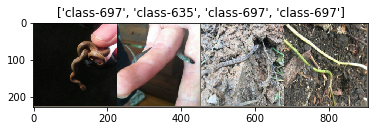

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train_data']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Train model

The next step would be to train a pretrained model on our dataset to fine tune the model.

In [13]:
# This code cannot be trusted, it seems to return the worst model
from sklearn.metrics import cohen_kappa_score, f1_score, precision_score,recall_score
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        predics = []
        labs = []
        # Each epoch has a training and validation phase
        for phase in ['train_data', 'val_data']:
            if phase == 'train_data':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_cohens = 0.0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train_data'):
                    outputs = model(inputs)
                    predics.append(outputs)
                    labs.append(labels)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train_data':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            print('F1: {}'.format(f1_score(labs, predics, average="samples")))
            print('Precision: {}'.format(precision_score(labs, predics, average="samples")))
            print('Recall: {}'.format(recall_score(labs, predics, average="samples")))
            kappa = metrics.cohen_kappa_score(labs, predics, weights='quadratic')
            print("Cohen kappa score =", kappa)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing specifications of our model

Once trained we will visualize our model using this method

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val_data']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Configuring model

We have 45 unique classes and we will be using resnet18 with pretrained weights, we will be adding a fully connected layer at the end to fine tune the pretrained model. This way of training a machine learning model is known as transfer learning.

We will be using categorical crossentropy as our loss function which is highly suitable for multi category classification.

We will be using basic Stochastic Gradient Descent to optimize our loss with decay of learning rate for better convergence

In [16]:
num_classes = 45

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Finally we train our model using the method defined above

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=40)

Epoch 0/39
----------


/files2c/1106817/.conda/envs/snakes/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [ ]:
torch.save(model_ft)

Here we have some predictions by our model which was fine tuned with 5 epochs

In [ ]:
visualize_model(model_ft)

### Summary


1) We split the give data into training and validation data

2) We normalized all the images, so they fit into the model we will be using

3) We use resnet18 with pretrained weights and add a fully connected layer to it. This way we fine tune the model on our data

4) We train our model for 5 epochs and check accuracy on the validation data

5) It was observed that we got an accuracy of 0.64 on our validation data which was never seen by our model